# Direct method
$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 5 < x_1 < 10 \} \text{ and } \{x \in \mathbb{R}^2 \mid 20 < x_1 < 25 \} \text{ are loss control regions.}
    \end{array}
    \right.
$$

In [1]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
mutable struct DirecTSS
    t; x1; x2 ; λ ; u ; xu ; xv ; p1 ; p2
end

In [3]:
function indicator(x, a, b)
    k = 17 
    g1 = 1 / (1 + exp(-k * (x - a)))  
    g2 = 1 / (1 + exp(-k * (b - x)))  
    return g1 * g2
end
f1(x)  = indicator(x,  4.8, 10.2) ;
f2(x)  = indicator(x, 19.8, 25.2) ;
fC(x)  = (1. - f1(x))*(1. - f2(x))
fNC(x) = (f2(x) + f1(x))
plot(fNC, -1, 30);

In [4]:
function ZERMELO(x0, ε ; solution=[], nsteps=700, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
      -1e1  ≤    xv[1:N+1]
      -1e1  ≤    xu[1:N+1]  
                 x1[1:N+1]                  # x1
                 x2[1:N+1]                  # x2
      -π/2  ≤     λ[1:N+1]  ≤ π/2           # regionally switching paramter
      -π/2  ≤     u[1:N+1]  ≤ π/2           # Control
      -1e1  ≤     v[1:N+1]  ≤ 1e1 

        end)
    
    Δt  =  8/N 
    
    # Objective
        @NLobjective(sys, Min, - x1[N+1] + ε*xv[N+1] + xu[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_xu0, xu[1]   == 0.0
        con_xv0, xv[1]   == 0.0
        con_x10, x1[1]   == x0[1]                #initial condition
        con_x20, x2[1]   == x0[2]                #initial condition
        con_x2f, x2[N+1] == 4.0                  #final condition 
        con_x30, -π/2 <= λ[1]   <= π/2 
        con_x3f, -π/2 <= λ[N+1] <= π/2 
        end)
    
    # Dynamics


    @NLexpression(sys, dx1[j=1:N+1],   fC(x1[j])*(x2[j] + cos(u[j])) + fNC(x1[j])*(x2[j] + cos(λ[j])) )

    @NLexpression(sys, dx2[j=1:N+1],   fC(x1[j])*sin(u[j]) + fNC(x1[j])*sin(λ[j]))
    
    @NLexpression(sys,  dλ[j = 1:N+1], fC(x1[j])*v[j])
    
    @NLexpression(sys, dxv[j = 1:N+1], (v[j]^2))
    
    @NLexpression(sys, dxu[j = 1:N+1], fNC(x1[j])*u[j]^2)
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N],  λ[j+1] ==  λ[j] + 0.5 * Δt * (dλ[j+1]  + dλ[j])
        con_dxv[j=1:N], xv[j+1] == xv[j] + 0.5 * Δt * (dxv[j+1] + dxv[j])
        con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1  = value.(x1)[:]
    x2  = value.(x2)[:]
    λ   = value.(λ)[:]
    u   = value.(u)[:]
    xu  = value.(xu)[:]
    xv  = value.(xv)[:]
    t   = (0:N) * value.(Δt)
    
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

    return DirecTSS(t, x1, x2, λ, u, xu , xv, p1, p2)
        
end;

In [5]:
# Resolution
x0  = [0.0; 0.0]

ε   = 1e-3 ; 

sol_direct = ZERMELO(x0, ε, nsteps = 600);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19205
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:    25200

Total number of variables............................:     4207
                     variables with only lower bounds:     1202
                variables with lower and upper bounds:     1803
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3005
Total number of in

  (Local) solution found
  objective value = -30.36015047327448



┌ Warning: Function fNC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fNC, 1, fNC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370
┌ Warning: Function fC automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :fC, 1, fC; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


xu = 0.027080009614140088
xv = 1.5118878726290865


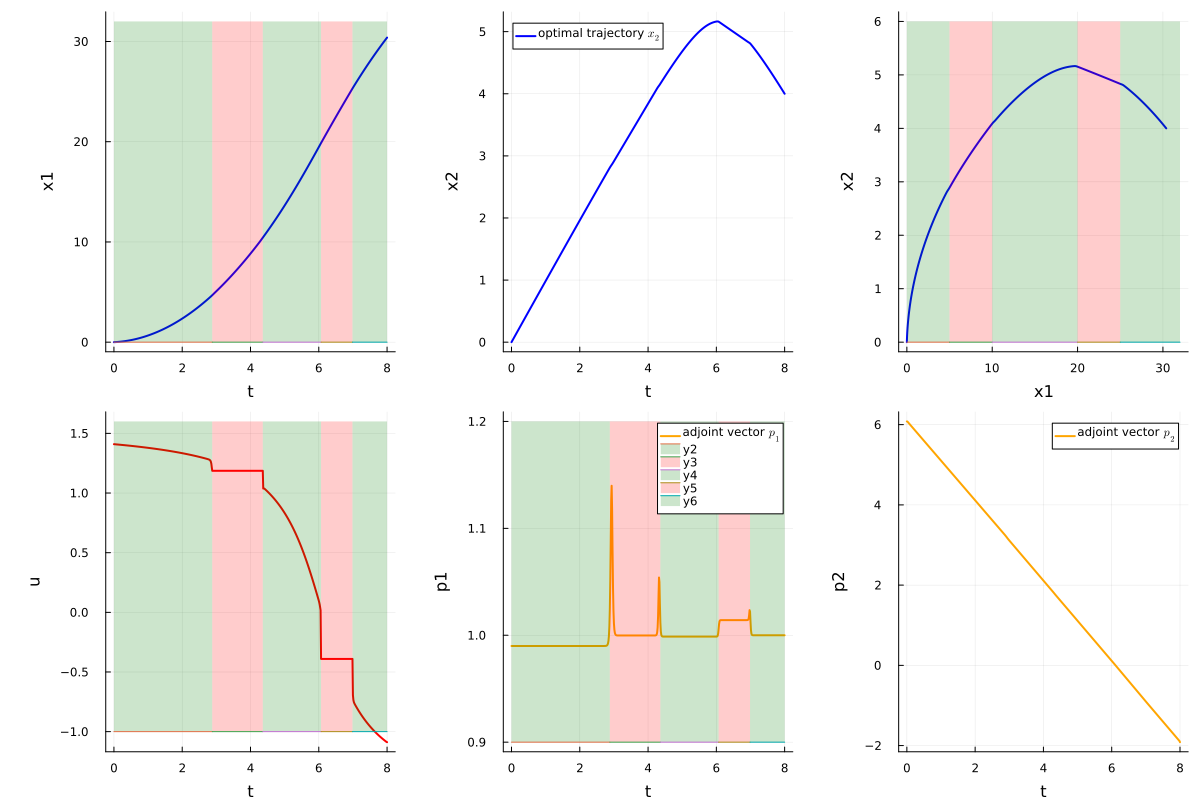

In [126]:
# Plots

t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
xu = sol_direct.xu
xv = sol_direct.xv
λ  = sol_direct.λ
p1  = sol_direct.p1
p2  = sol_direct.p2

println("xu = ", xu[end])
println("xv = ", xv[end])

index1 = findfirst(abs.(u) .<= 0.01)

index2 = 0
for i in (index1+1):length(u)
    if abs(u[i]) >= 0.01
        index2 = i
        break
    end
end

index3 = 0
for i in (index2+1):length(u)
    if abs(u[i]) <= 0.01
        index3 = i
        break
    end
end

index4 = 0
for i in (index3+1):length(u)
    if abs(u[i]) >= 0.01
        index4 = i
        break
    end
end

t1 = t[index1 - 10]
t2 = t[index2 + 8 ]
t3 = t[index3]
t4 = t[index4 + 4]

u1   = copy(u) ; 
u1[t1  .<= t .<= t2] .= λ[div(index1+index2, 2)]
u1[t3  .<= t .<= t4] .= λ[div(index3 + index4, 2)]



x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  label=L"optimal trajectory $x_1$", legend = false,linecolor=:blue, linewidth=2)
plot!(x1_plot, [0.0, t1], [0.0, 0.0], fillrange = 32, fillalpha = 0.2, fillcolor = :green)
plot!(x1_plot, [t1, t2],  [0.0, 0.0], fillrange = 32, fillalpha = 0.2, fillcolor = :red)
plot!(x1_plot, [t2, t3],  [0.0, 0.0], fillrange = 32, fillalpha = 0.2, fillcolor = :green)
plot!(x1_plot, [t3, t4],  [0.0, 0.0], fillrange = 32, fillalpha = 0.2, fillcolor = :red)
plot!(x1_plot, [t4, t[end]],[0,   0], fillrange = 32, fillalpha = 0.2, fillcolor = :green)

x3_plot   = plot(t,  λ, xlabel = "t",  ylabel = "λ",  label=L"optimal trajectory $x_1$", linecolor=:blue, linewidth=2)

x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", label=L"optimal trajectory $x_2$",linecolor=:blue,linewidth=2)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", label=L"adjoint vector $p_1$",linecolor=:orange, linewidth=2)
plot!(p1_plot, [0.0, t1], [0.9, 0.9], fillrange = 1.2, fillalpha = 0.2, fillcolor = :green)
plot!(p1_plot, [t1, t2], [0.9, 0.9], fillrange = 1.2, fillalpha = 0.2, fillcolor = :red)
plot!(p1_plot, [t2, t3], [0.9, 0.9], fillrange = 1.2, fillalpha = 0.2, fillcolor = :green)
plot!(p1_plot, [t3, t4], [0.9, 0.9], fillrange = 1.2, fillalpha = 0.2, fillcolor = :red)
plot!(p1_plot, [t4, t[end]], [0.9, 0.9], fillrange = 1.2, fillalpha = 0.2, fillcolor = :green)

p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", label=L"adjoint vector $p_2$",linecolor=:orange,linewidth=2)
u_plot    = plot(t,   u1, xlabel = "t", ylabel = "u",   label=L"optimal control $u$",legend = false,linecolor=:red ,linewidth=2) 
plot!(u_plot, [0.0, t1], [-1.0, -1.0],    fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)
plot!(u_plot, [t1, t2], [-1.0, -1.0],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :red)
plot!(u_plot, [t2, t3], [-1.0, -1.0],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)
plot!(u_plot, [t3, t4], [-1.0, -1.0],     fillrange = 1.6, fillalpha = 0.2, fillcolor = :red)
plot!(u_plot, [t4, t[end]], [-1.0, -1.0], fillrange = 1.6, fillalpha = 0.2, fillcolor = :green)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  label=L"optimal trajectory $x$", legend = false,linecolor=:blue,linewidth=2)
plot!(x1x2_plot, [0.0, 5.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green)
plot!(x1x2_plot, [5., 10.],  [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [10., 20.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green)
plot!(x1x2_plot, [20., 25.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :red)
plot!(x1x2_plot, [25., 32.], [0.0, 0.0], fillrange = 6, fillalpha = 0.2, fillcolor = :green)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot, p2_plot , layout = (2,3), size=(1200,800), left_margin=10mm)

In [125]:
jmp1 = p1[div(index1 + index2, 2)] - p1[div(index1 + 1, 2)]
jmp2 = p1[div(index2 + index3, 2)] - p1[div(index1 + index2, 2)]
jmp3 = p1[div(index3 + index4, 2)] - p1[div(index2 + index3, 2)]
jmp4 = p1[div(index4 + length(t), 2)] - p1[div(index3 + index4, 2)]
#λ[index1+index2]
λ[div(index1+index2, 2)]

1.1863017314006155

# Indirect method

In [110]:
using NLsolve
using Plots
using Plots.PlotMeasures
using Animations
using Reel
include("flow.jl");
using LinearAlgebra;

In [111]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [  sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)                               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )                      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region 1
H2(x, a, y, p)   = p' * F(x, a)   + y* p' *G(a)           # pseudo-Hamiltonian
Hcl1(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])         # control loss1

fcl1  = Flow(Hcl1);

# Hamiltonians: control loss region 1
H3(x, b, y, p)   = p' * F(x, b)   + y* p' *G(b)          # pseudo-Hamiltonian
Hcl2(X, P)       = H3(X[1:2], X[3], X[4], P[1:2])           # control loss2

# Flows
fcl2  = Flow(Hcl2);

In [142]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]


# Shooting function
function shoot(p0, tt1, tt2, tt3, tt4, a1, b1, j1, j2, j3, j4) 
    
    pa0    = 0.0 
    pb0    = 0.0 
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    
    X2, P2 = fcl1(tt1, [x1; a1 ; 0.0], [p1- [0. , j1]; pa0 ; py0], tt2) 
    
    
    x3, p3 = fc(tt2, X2[1:2], P2[1:2] - [0. , j2], tt3)
    

    X4, P4 = fcl2(tt3, [x3; b1 ; 0.0], [p3- [0. , j3]; pb0 ; py0], tt4)
    
 
    xf, pf = fc(tt4, X4[1:2], P4[1:2] - [0. , j4], tf)


    s = zeros(eltype(p0), 12)
    s[1]  = xf[2] - x2f   # target
    s[2]  = pf[1] - 1.0   # transversality condition
    s[3]  = x1[1] - 5.0   # first crossing 
    s[4]  = X2[1] - 10.0  # second crossing 
    s[5]  = x3[1] - 20.0  # first crossing 
    s[6]  = X4[1] - 25.0  # second crossing 
    s[7]  = P2[4]         # averaged gradient condition1
    s[8]  = P4[4]         # averaged gradient condition2
    s[9]  = j1 - p1[2]*(a1 - u11(x1, p1))/(x1[2])
    s[10] = j2 - P2[2]*(u11(X2[1:2], P2[1:2]) - a1)/(X2[2])
    s[11] = j3 - p3[2]*(b1 - u11(x3, p3))/(x3[2])
    s[12] = j4 - P4[2]*(u11(X4[1:2], P4[1:2]) - b1)/(X2[2])

    return s

end;


In [143]:
S(ξ)    = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7], ξ[8], ξ[9], ξ[10], ξ[11], ξ[12]) ;

In [144]:
ξ_guess = [p1[1], p2[1], t1, t2,t3,t4, λ[div(index1+index2, 2)], λ[div(index3 + index4, 2)], jmp1, jmp2, jmp3, jmp4]; # initial guess


In [145]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[0.0631211299488399, -0.010028700648110789, -0.31553257636830434, 0.415173733998472, -0.10765809164305296, 0.38134379572198895, 0.022404946594474236, 0.0019425757589739846, 0.10979578889444959, 0.05316766516675798, 0.021199273837419905, -0.08105743975440174]




In [147]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    tt3 = indirect_sol.zero[5]
    tt4 = indirect_sol.zero[6]
    a1  = indirect_sol.zero[7]
    b1  = indirect_sol.zero[8]
    j11 = indirect_sol.zero[9]
    j22 = indirect_sol.zero[10]
    j33 = indirect_sol.zero[11]
    j44 = indirect_sol.zero[12]
    
else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.151737e-01              NaN
     1     6.037090e-03     2.206813e-01
     2     3.120250e-06     2.489269e-03
     3     1.875833e-12     1.108808e-06
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.9899712993518892, 6.080452103181542, 2.88, 4.36, 6.066666666666666, 6.986666666666666, 1.1863017314006155, -0.39027052611349533, 0.009810407755428519, -0.0010420052373537603, 0.015433511805543976, -0.014173213675507945]
 * Zero: [1.0, 5.976416764894094, 2.974334306096851, 4.265350546509115, 6.083462199446875, 6.923763932103453, 1.1801408831319076, -0.3819310162301473, -0.07166326823684141, -0.05255603108021508, -0.0013234767982517142, 0.06149257312854786]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx

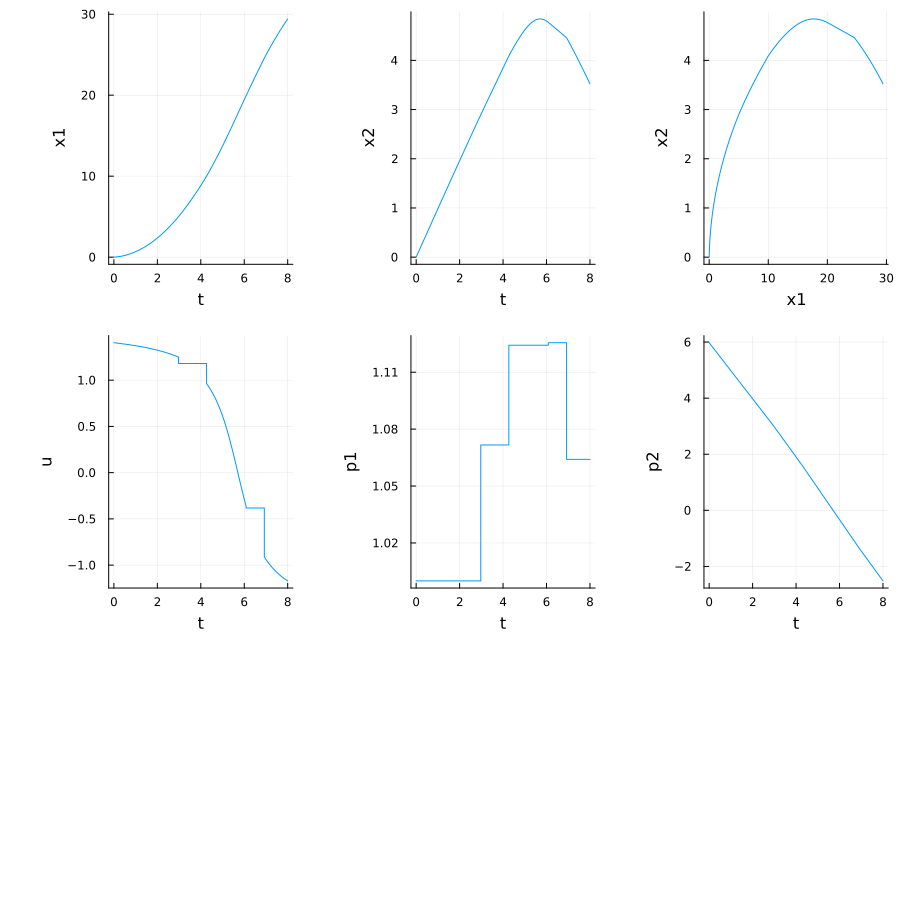

In [148]:
#Plots

pa0 = 0. 
pb0 = 0. 
py0 = 0.
pz0 = 0.


ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1     = u11.(xx1, pp1)  ;



ode_sol = fcl1((tt1, tt2), [xx1[end] ; a1 ; 0.0], [pp1[end]- [ j11, 0.]; pa0 ; py0], saveat=0.1)
ttt2    = ode_sol.t
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2     = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2     = a1.*ones(length(ttt2)) ;


ode_sol = fc((tt2, tt3), xx2[end],  pp2[end] - [j22, 0.], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;

ode_sol = fcl2((tt3, tt4), [xx3[end] ; b1 ; 0.0], [pp3[end] - [j33, 0.]; pb0 ; pz0], saveat=0.1)
ttt4 = ode_sol.t
xx4 = [ ode_sol[1:2, j] for j in 1:size(ttt4, 1) ]
pp4 = [ ode_sol[5:6, j] for j in 1:size(ttt4, 1) ] 
uu4 = b1.*ones(length(ttt4)) ;

ode_sol = fc((tt4, tf), xx4[end], pp4[end]- [j44, 0.], saveat=0.1)
ttt5 = ode_sol.t
xx5 = [ ode_sol[1:2, j] for j in 1:size(ttt5, 1) ]
pp5 = [ ode_sol[3:4, j] for j in 1:size(ttt5, 1) ] 
uu5 = u11.(xx5, pp5)  ;


t = [ ttt1 ; ttt2 ; ttt3 ; ttt4 ; ttt5]
x = [ xx1 ; xx2 ; xx3 ; xx4 ; xx5 ]
p = [ pp1 ; pp2 ; pp3 ; pp4 ; pp5 ]
u = [ uu1 ; uu2 ; uu3 ; uu4 ; uu5 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot ,p2_plot , layout = (3,3), size=(900,900), left_margin=10mm)

In [30]:
# create an animation
animx = @animate for i = 1:length(t)
    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(0.,7.), xlabel="x1", ylabel="x2", label="x", linecolor=:blue)
end

# create an animation
animu = @animate for i = 1:length(t)
    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="u", linecolor=:red)
end 

Plots.Animation("/tmp/jl_zdtEih", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000492.png", "000493.png", "000494.png", "000495.png", "000496.png", "000497.png", "000498.png", "000499.png", "000500.png", "000501.png"])

[ Info: Saved animation to /home/anas/Documents/control-loss/animationx.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/animationx.gif")
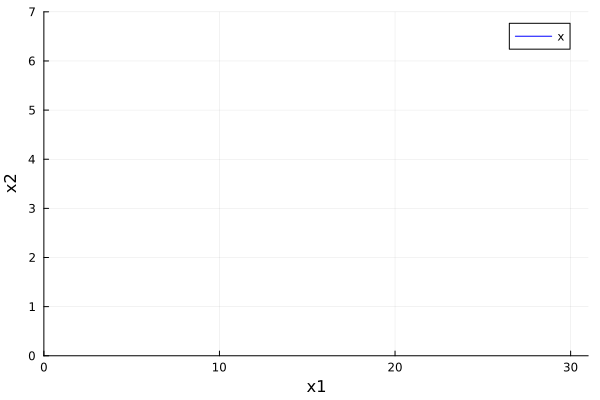

In [15]:
# display the animation
gif(animx, "animationx.gif", fps = 15)

[ Info: Saved animation to /home/anas/Documents/control-loss/animationx.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/animationx.gif")
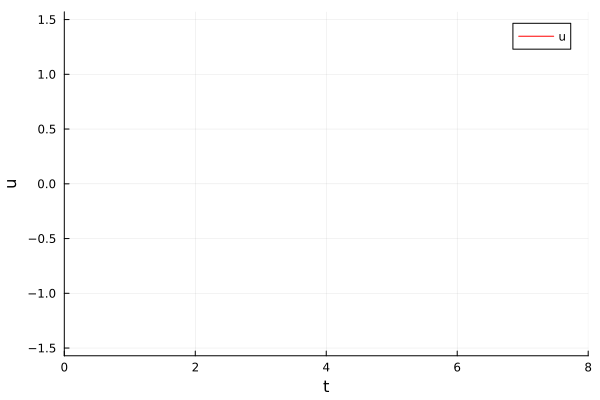

In [16]:
gif(animu, "animationx.gif", fps = 15)